## The goal of Decision Tree is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             459 non-null    float64
 1   bath            459 non-null    float64
 2   acre_lot        459 non-null    float64
 3   zip_code        459 non-null    float64
 4   house_size      459 non-null    float64
 5   prev_sold_date  459 non-null    object 
 6   price           459 non-null    float64
dtypes: float64(6), object(1)
memory usage: 25.2+ KB


#### Create new feature prev_sold_year from prev_sold_date

In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             459 non-null    float64
 1   bath            459 non-null    float64
 2   acre_lot        459 non-null    float64
 3   zip_code        459 non-null    float64
 4   house_size      459 non-null    float64
 5   price           459 non-null    float64
 6   prev_sold_year  459 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 25.2 KB


#### Read the file containing Latitude and Longitude

In [5]:
zip_lon_lat = pd.read_csv('ma_zip-lon-lat.csv')
zip_lon_lat.head()

,zip_code,latitude,longitude
0,1001,42.062368,-72.625754
1,1002,42.364061,-72.458739
2,1003,42.389941,-72.524108
3,1005,42.418848,-72.106598
4,1007,42.279010,-72.400468


#### Merge the Lat/Long data with the housing data using Zip Code

In [6]:
merged_df = pd.merge(outliers_df, zip_lon_lat, how='inner', on="zip_code")
merged_df.tail()

,bed,bath,acre_lot,zip_code,house_size,price,prev_sold_year,latitude,longitude
454,1.0,1.0,0.17,2657.0,280.0,449000.0,2019,42.059829,-70.200407
455,2.0,1.0,0.17,2657.0,420.0,559000.0,2021,42.059829,-70.200407
456,3.0,3.0,0.35,2657.0,2820.0,1499000.0,2018,42.059829,-70.200407
457,2.0,1.0,0.23,2723.0,612.0,149000.0,2021,41.692705,-71.129726
458,3.0,1.0,0.13,2724.0,1270.0,399000.0,2016,41.683936,-71.177500


#### Create common variables to store frequently used values.

In [7]:
features = ["latitude","longitude","bed","bath","house_size","prev_sold_year"]
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [8]:
X = merged_df[features]
y = merged_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [9]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [10]:
def print_more_stuff(title, y_param, predict_param, gscv):
    results_dict["model"].append(title)
    
    evs = "{:.9f}".format(explained_variance_score(y_param,predict_param))
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    #find_best_params = gscv.cv_results_["params"].index(gscv.best_params_)
    #mean_fit_time = gscv.cv_results_["mean_fit_time"][find_best_params]
    mean_fit_time = gscv.cv_results_["mean_fit_time"][gscv.best_index_]
    
    results_dict["explained variance score"].append(evs)
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)
    results_dict["mean fit time"].append(mean_fit_time)
    
    print(title + " EVS = " + evs)
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)
    print(title + " Fit Time = " + str(mean_fit_time))

### GridSearchCV exhaustively generates candidates from a grid of parameter values specified.

In [11]:
params = {'max_depth': range(5,10,1),
         'random_state':[42]}

grid = GridSearchCV(DecisionTreeRegressor(), param_grid=params).fit(X_train, y_train)
grid_train_acc = grid.score(X_train, y_train)
grid_test_acc = grid.score(X_test, y_test)
best_params = grid.best_params_
best_params

{'max_depth': 6, 'random_state': 42}

#### The best params attribute will be used to fit  model with the training data and make a prediction with the test data.

In [12]:
dtree = DecisionTreeRegressor(**best_params)
dtree_gscv = GridSearchCV(dtree, param_grid={})
dtree_model = dtree_gscv.fit(X_train,y_train)
dtree_bp_predict = dtree_model.predict(X_test)

print_more_stuff("Decision Tree Best Params", y_test, dtree_bp_predict, dtree_gscv)

Decision Tree Best Params EVS = 0.551812072
Decision Tree Best Params MSE = 186,150,467,078.847839
Decision Tree Best Params MAE = 259,135.814821
Decision Tree Best Params R2 = 0.550242
Decision Tree Best Params Fit Time = 0.0025044918060302735


#### cost_complexity_pruning_path

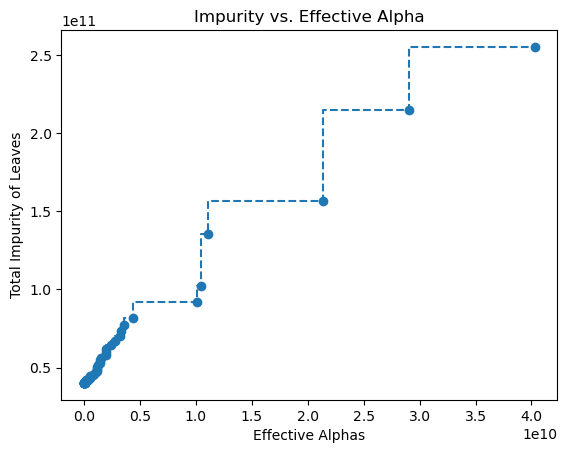

In [13]:
path = dtree.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas
impurities = path.impurities

plt.step(ccp_alphas[:-1], impurities[:-1], '--o')
plt.title('Impurity vs. Effective Alpha')
plt.xlabel('Effective Alphas')
plt.ylabel('Total Impurity of Leaves');

### Recursive feature elimination uses an external estimator that assigns weights to features with the goal of selecting features by recursively considering smaller and smaller sets of features.

In [14]:
dtree_rfe = RFE(DecisionTreeRegressor(), n_features_to_select=num_features_to_select)
dtree_rfe.fit(X, y)
dtree_rfe_selected_features = dtree_rfe.get_support()
print('The selected features are:', list(X.columns[dtree_rfe_selected_features]))

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']


In [15]:
X_rfe = merged_df[list(X.columns[dtree_rfe_selected_features])]
y_rfe = merged_df["price"]
X_rfe_train, X_rfe_test, y_rfe_train, y_rfe_test = train_test_split(X_rfe, y_rfe, test_size=0.3, random_state=random_state_value)

In [16]:
dtree_rfe_gscv = GridSearchCV(DecisionTreeRegressor(),param_grid={})
dtree_rfe_model = dtree_rfe_gscv.fit(X_rfe_train,y_rfe_train)
dtree_rfe_predict = dtree_rfe_model.predict(X_rfe_test)

print_more_stuff("Recursive Feature Elimination", y_rfe_test, dtree_rfe_predict, dtree_rfe_gscv)

Recursive Feature Elimination EVS = 0.579610470
Recursive Feature Elimination MSE = 173,998,244,815.913055
Recursive Feature Elimination MAE = 251,680.391304
Recursive Feature Elimination R2 = 0.579603
Recursive Feature Elimination Fit Time = 0.0027576446533203124


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator. 

In [17]:
dtree_sfs = SequentialFeatureSelector(DecisionTreeRegressor(), n_features_to_select=num_features_to_select)
dtree_sfs.fit(X, y)
dtree_sfs_selected_features = dtree_sfs.get_support()
print('The selected features are:', list(X.columns[dtree_sfs_selected_features]))

The selected features are: ['latitude', 'longitude', 'bed', 'house_size', 'prev_sold_year']


In [18]:
X_sfs = merged_df[list(X.columns[dtree_sfs_selected_features])]
y_sfs = merged_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [19]:
dtree_sfs_gscv = GridSearchCV(DecisionTreeRegressor(),param_grid={})
dtree_sfs_model = dtree_sfs_gscv.fit(X_sfs_train,y_sfs_train)
dtree_sfs_predict = dtree_sfs_model.predict(X_sfs_test)
dtree_sfs_mse = mean_squared_error(y_sfs_test,dtree_sfs_predict)

print_more_stuff("Sequential Feature Selector", y_sfs_test, dtree_sfs_predict, dtree_sfs_gscv)

Sequential Feature Selector EVS = 0.586577140
Sequential Feature Selector MSE = 171,488,457,095.463776
Sequential Feature Selector MAE = 247,850.927536
Sequential Feature Selector R2 = 0.585667
Sequential Feature Selector Fit Time = 0.003156423568725586


#### Graphing the results works best when the data is provided in a DataFrame.

In [20]:
dtree_bp_predict_df = pd.DataFrame(dtree_bp_predict).reset_index()
dtree_bp_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_sfs_predict_df = pd.DataFrame(dtree_sfs_predict).reset_index()
dtree_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_rfe_predict_df = pd.DataFrame(dtree_rfe_predict).reset_index()
dtree_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

#### The predictions provided by the best parameters have the appearance of banding.  I will conduct more testing to determine if this is acceptable or if this is a case of underfitting or overfitting.

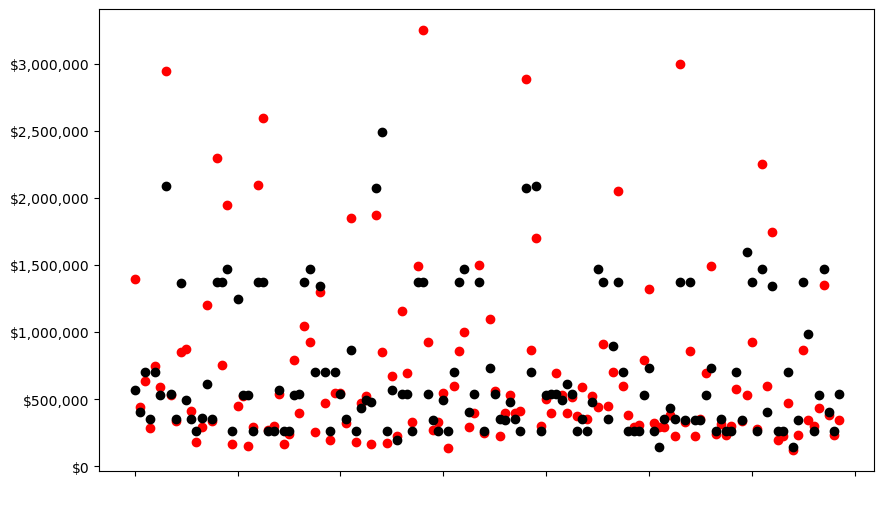

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(dtree_bp_predict_df.index,dtree_bp_predict_df["prediction"], color="black")
plt.show()

#### Scatter Plot graph of the results of Recursive Feature Elimination, Sequential Feature Selection, and Test Data.

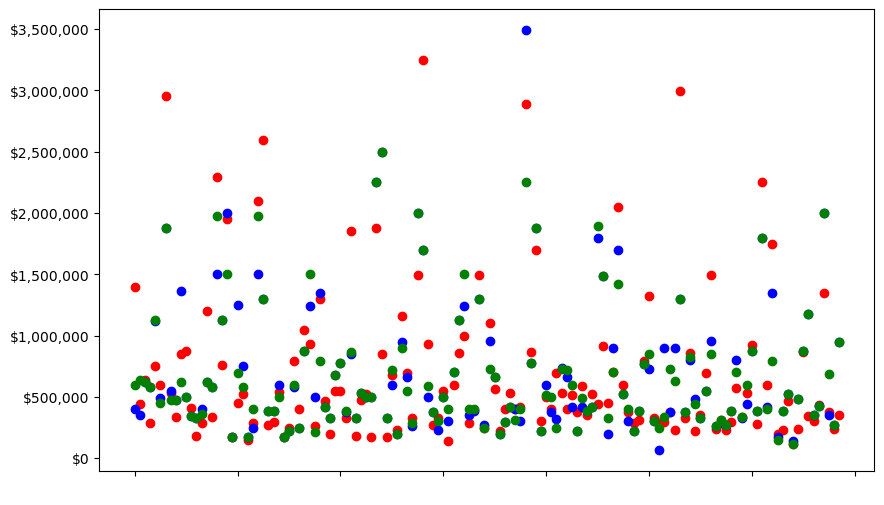

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(dtree_rfe_predict_df.index,dtree_rfe_predict_df["prediction"], color="blue")
plt.scatter(dtree_sfs_predict_df.index,dtree_sfs_predict_df["prediction"], color="green")
plt.show()

#### Sort the DataFrames by the Prediction and Price features.

In [23]:
dtree_bp_predict_df.sort_values(by='prediction', inplace=True)
dtree_bp_predict_df.reset_index(inplace=True)

dtree_sfs_predict_df.sort_values(by='prediction', inplace=True)
dtree_sfs_predict_df.reset_index(inplace=True)

dtree_rfe_predict_df.sort_values(by='prediction', inplace=True)
dtree_rfe_predict_df.reset_index(inplace=True)

y_test_df.sort_values(by='price', inplace=True)
y_test_df.reset_index(inplace=True)

#### Line graph of the results of Recursive Feature Elimination, Sequential Feature Selection, and Test Data.

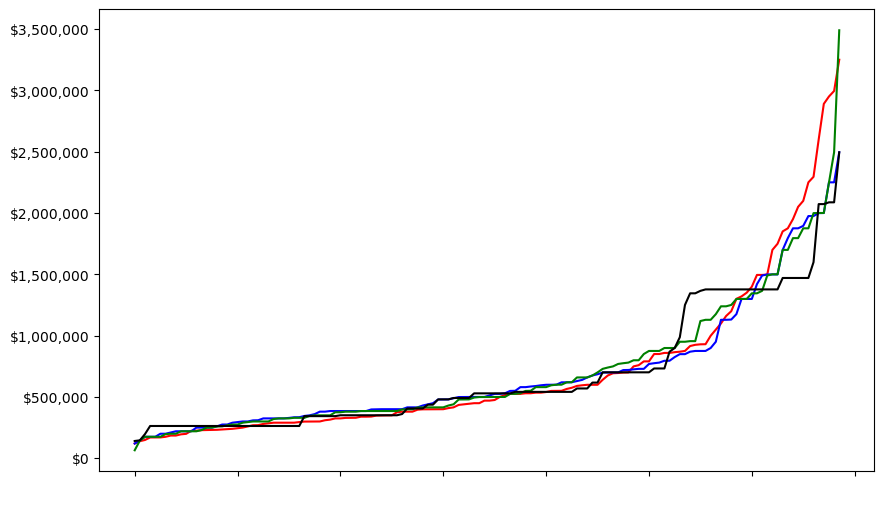

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.plot(y_test_df.index,y_test_df["price"], color="red")
plt.plot(dtree_sfs_predict_df.index,dtree_sfs_predict_df["prediction"], color="blue")
plt.plot(dtree_rfe_predict_df.index,dtree_rfe_predict_df["prediction"], color="green")
plt.plot(dtree_bp_predict_df.index,dtree_bp_predict_df["prediction"], color="black")
plt.show()

#### Output the results so they can be copied into another Notebook comparing the results of all the models.

In [25]:
results_dict

{'model': ['Decision Tree Best Params',
  'Recursive Feature Elimination',
  'Sequential Feature Selector'],
 'explained variance score': ['0.551812072', '0.579610470', '0.586577140'],
 'mae score': ['259,135.814821', '251,680.391304', '247,850.927536'],
 'mse score': ['186,150,467,078.847839',
  '173,998,244,815.913055',
  '171,488,457,095.463776'],
 'r2 score': ['0.550242', '0.579603', '0.585667'],
 'mean fit time': [0.0025044918060302735,
  0.0027576446533203124,
  0.003156423568725586]}

In [26]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Decision Tree Best Params,0.551812072,"259,135.814821","186,150,467,078.847839",0.550242,0.002504
Recursive Feature Elimination,0.579610470,"251,680.391304","173,998,244,815.913055",0.579603,0.002758
Sequential Feature Selector,0.586577140,"247,850.927536","171,488,457,095.463776",0.585667,0.003156
